In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()  
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


In [14]:
class FVSBN(nn.Module):
    def __init__(self, input_dim):
        super(FVSBN, self).__init__()
        self.input_dim = input_dim
        self.bias = nn.Parameter(torch.zeros(input_dim))
        self.weights = nn.Parameter(torch.zeros(input_dim, input_dim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        probs = torch.zeros_like(x)
        
        for i in range(self.input_dim):
            linear_combination = self.bias[i] + torch.matmul(x[:, :i], self.weights[i, :i])
            probs[:, i] = self.sigmoid(linear_combination)
        
        return probs

    def sample(self, batch_size):
        samples = torch.zeros(batch_size, self.input_dim).to(device)
        for i in range(self.input_dim):
            linear_combination = self.bias[i] + torch.matmul(samples[:, :i], self.weights[i, :i])
            probs = self.sigmoid(linear_combination)
            samples[:, i] = torch.bernoulli(probs)
        return samples


In [15]:
def train_fvsbn(model, data_loader, optimizer, epochs):
    model.train()
    loss_fn = nn.BCELoss()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            x, _ = batch
            x = x.view(x.size(0), -1).to(device)  
            
            probs = model(x)
            loss = loss_fn(probs, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}")

input_dim = 28 * 28
fvsbn_model = FVSBN(input_dim).to(device)
optimizer = optim.Adam(fvsbn_model.parameters(), lr=0.001)

train_fvsbn(fvsbn_model, train_loader, optimizer, epochs=10)


Epoch 1/10, Loss: 0.2922
Epoch 2/10, Loss: 0.1913
Epoch 3/10, Loss: 0.1538
Epoch 4/10, Loss: 0.1336
Epoch 5/10, Loss: 0.1216
Epoch 6/10, Loss: 0.1140
Epoch 7/10, Loss: 0.1090
Epoch 8/10, Loss: 0.1056
Epoch 9/10, Loss: 0.1033
Epoch 10/10, Loss: 0.1016


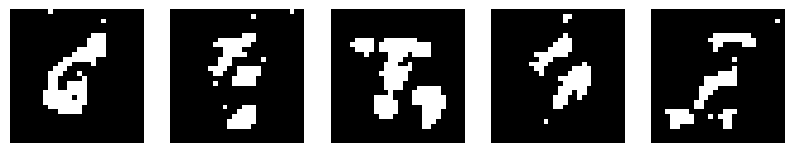

In [30]:
def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        samples = model.sample(num_samples)
        samples = samples.view(num_samples, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.show()

generate_samples(fvsbn_model, num_samples=5)


In [17]:
def evaluate_log_likelihood(model, data_loader):
    model.eval()
    log_likelihood = 0
    with torch.no_grad():
        for batch in data_loader:
            x, _ = batch
            x = x.view(x.size(0), -1).to(device)
            probs = model(x)
            log_prob = x * torch.log(probs + 1e-8) + (1 - x) * torch.log(1 - probs + 1e-8)
            log_likelihood += log_prob.sum().item()
    
    avg_log_likelihood = log_likelihood / len(data_loader.dataset)
    print(f"Average Log-Likelihood: {avg_log_likelihood:.4f}")


In [18]:
evaluate_log_likelihood(fvsbn_model,train_loader)

Average Log-Likelihood: -78.8447
